Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says "YOUR ANSWER HERE" or `YOUR CODE HERE` and remove the `raise NotImplementedError()` lines. 

Code blocks starting with a `# tests` comment provide unit tests which have to run without errors in order to get full points. Be aware that there might be further 'secret' tests to check correct implementation! I.e. the provided unit tests are necessary but not sufficient for full points!

You are always welcome to add **additional plots, tests, or debug outputs**.
However, make sure to: **1) not break the automated tests**, and **2) switch off any excessive debug output** when you submit your notebook!

Please add your name and student ID below:

In [1]:
NAME = "Konstantinos Vakalopoulos" 
STUDENT_ID = "12223236" 
# YOUR CODE HERE
# raise NotImplementedError()

In [2]:
assert len(NAME) > 0, "Enter your name!"
assert len(STUDENT_ID) > 0, "Enter your student ID!"

## Intelligent Audio and Music Analysis Assignment 3
## Tempo Estimation and Beat Tracking

In this assignment we will explore methods to estimate the tempo and find the beats of music stored as PCM audio.
The methods we will use are by no means the only way to do this. But they are quite simple, intuitive, and also perform reasonably well, given how basic they are.

## Data

As in the last assignment, we will use the dataset stored in numpy arrays. So first, let's load the data from the numpy archives:


In [3]:
# DO NOT COPY OR MODIFY THIS CELL!!
import numpy as np
import os
import traceback

dataset_path = os.path.join(os.environ['HOME'], 'shared', '194.039-2023W', 'data', 'assignment_3')
if os.path.exists('data.npz'):
    dataset_path = '.'

audio_sample_rate = 44100
spec_frame_rate = 100
spec_freq_bins = 40

audio_data = np.load(os.path.join(dataset_path, 'data.npz'), allow_pickle=True, mmap_mode='r')

tempo_data = np.load(os.path.join(dataset_path, 'tempo.npz'), allow_pickle=True, mmap_mode='r')
beat_data = np.load(os.path.join(dataset_path, 'beats.npz'), allow_pickle=True, mmap_mode='r')

print(audio_data.files)
print(tempo_data.files)
print(beat_data.files)

['names', 'audio', 'spectrograms']
['annotations', 'audio_idxs']
['annotations', 'audio_idxs']


In [4]:
example_idx = 109

In [5]:
# DO NOT COPY OR MODIFY THIS CELL!!

# NOTE that for both the beat and tempo annotations, we have an entry
# 'audio_idxs' which indicates for which audio file the annotations are. 
# Beat and tempo annotations exist only for a subset of the audio files
# The example with audio_idx 109 is one that has both.

# Find corresponding indices for annotations:
beats_example_idx = np.argwhere(beat_data['audio_idxs']==example_idx)[0][0]
tempo_example_idx = np.argwhere(tempo_data['audio_idxs']==example_idx)[0][0]

# get annotations from onset data archive:
example_tempo_ann = tempo_data['annotations'][tempo_example_idx]
example_beats_ann = beat_data['annotations'][beats_example_idx]

# get the correct audio related data from the audio archive:
example_audio_name = audio_data['names'][example_idx]
example_audio = audio_data['audio'][example_idx]
example_spectrogram = audio_data['spectrograms'][example_idx]

print(example_spectrogram.shape)

# we can play the audio in this jupyter notebook
import IPython.display as ipd
print("audio for file '{}':".format(example_audio_name))
ipd.Audio(example_audio, rate=audio_sample_rate)

(1001, 40)
audio for file 'al_Albums-AnaBelen_Veneo-13(1.8-11.8)':


## Task 1: Estimate Tempo using the ACF of an ODF (10 Points)

The tempo of a piece of music is the average rate of quarter notes one would tap along with the music (like a metronom).
Usually this tempo is measured in beats per minutes (i.e. quarter notes per minute) or BPM.

A simple yet effective way to estimate the tempo of an audio file, is to use an onset detection function (ODF)
(we extracted the *spectral flux* ODF in assignment 2) and find periodicity patterns in it. 

In this assignment we will apply this method to estimate the tempo for the audio files in the dataset.
In order to detect the tempo i.e. the periodicity the ODF, the following procedure should be applied:

1. Compute the onset detection function (ODF).
2. Compute the autocorrelation function (ACF) of the ODF.
3. Calculate the BPM for the lag at the maximum of the ACF.

### 1.1 ODF calculation

Since we already covered ODF calculation in assignment 2, we will use the *librosa* implementation of *spectral_flux* in this assignment.

**OPTIONAL:** Once you finished the notebook, you are welcome to come back to this cell and try to improve the performance by using other onset detection functions. **DO NOT** change the ODF calculation before you have some reasonable results, since this may make it harder to complete the assignment successfully.

In [6]:
from librosa.onset import onset_strength

def onset_detection_function(spectrogram):
    return onset_strength(S=spectrogram.T)

### 1.2 ACF calculation

We use the same definition of the autocorrelation function as in the lecture:

$$ r(\tau) = \sum^{N-\tau-1}_{t=0}d(t+\tau) \cdot d(t) $$

where $r(\tau)$ is the autocorrelation at lag $\tau$ and $d(t)$ is the function for which the autocorrelation should be
calculated. In our case that is the onset detection function.

#### 1.2.1 Frame Lag to BPM
We only need to calculate $r(\tau)$ for lags that correspond to the BPM range that we are interested in.
In order to calculate the number of frames for a lag that corresponds to a certain tempo, we need a function to map
from BPM to a delta time in frames:

$$ BPM = \frac{60 \cdot fr}{\Delta t} $$

where $fr$ is the frame rate of our spectrogram, and $\Delta t$ is the distance between two quarter note onsets in
frames. Since BPMs and $\Delta t$ are conveniently inversely proportional, the same conversion function can be used in
both directions:

$$ \Delta t = \frac{60 \cdot fr}{BPM} $$

In [7]:
def bpm_to_frames(bpm, frame_rate=spec_frame_rate):
    """
    Converts from BPM to delta time in frames

    Parameters
    ----------
    bpm : float
        The tempo in beats per minute
    frame_rate : int, optional
        The rate of frames per second
    Returns
    -------
    float
        Delta time IN FRAME between two beats with bpm beat rate, at a frame rate frame_rate.
    """

    frames = None
    # YOUR CODE HERE
    # raise NotImplementedError()
    frames = 60*frame_rate/bpm
    return frames

In [8]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
assert bpm_to_frames(120, 1) == 0.5
assert bpm_to_frames(60, 100) == 100

print('All tests successful!')

All tests successful!


#### 1.2.2. Implement Autocorrelation Function (ACF)

Note for implementation: always use a minimum lag of 1 for $\tau$, we are never interested in a lag $\tau=0$ since that is always 100% correlated. Also, we circumvent some division by 0 problems that way.
    
**Hint**: [Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) is closely related to cross-correlation, which in turn is closely related to convolution.

In [9]:
# DO NOT COPY OR MODIFY THIS CELL!!
DEFAULT_MIN_BPM = 60
DEFAULT_MAX_BPM = 180

In [10]:
def autocorrelation(odf, min_bpm=DEFAULT_MIN_BPM, max_bpm=DEFAULT_MAX_BPM):
    """
    Calculates the autocorrelation for signal odf
    
    Parameters
    ----------
    odf : ndarray
        The vector with values for which ACF should be calculated. In our case this will be an ODF.
    min_bpm : float
        Minimum BPM value which defines the maximum lag for which the ACF should be calculated for.
    max_bpm : float
        Maximum BPM value which defines the minimum lag for which the ACF should be calculated for.        
    Returns
    -------
    acf : ndarray
        vector with length max_lag-min_lag containing the ACF values.
    lag_to_bpm : list
        bpm values for each lag corresponding to the index of acf.
    """

    acf = None
    lag_to_bpm = []
    # YOUR CODE HERE
    # raise NotImplementedError()

    max_lag = int(bpm_to_frames(min_bpm))
    min_lag = int(bpm_to_frames(max_bpm))
    
    if max_lag - min_lag > len(odf):
        acf = np.correlate(odf, odf, mode='full')[len(odf):]
        lag = list(range(1,len(odf)))
    else:
        acf = np.correlate(odf, odf, mode='full')[len(odf) + min_lag-1:len(odf) + max_lag-1]
        lag = list(range(min_lag,max_lag))

    lag_to_bpm = [60*spec_frame_rate/l for l in lag] 


    
    return acf,lag_to_bpm

In [11]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
# tests for ACF calculation

def test_mats(real, exp):
    assert len(real) == len(exp) and \
    np.allclose(real, exp), \
        "test failed: real {} expected {}".format(real, exp)
    
test_sig = np.zeros((100,))
# force to go from lag 0 to 6000 - this means full acf for our 100 samples test signal:
calc_res, lag_to_bpm = autocorrelation(test_sig, 1, 10000)
expc_res = np.zeros((100,))
# we always crop lag tau=0, so we expect the value for tau=0 to be missing
exp_res_trim = expc_res[1:]
assert len(lag_to_bpm) == 99
test_mats(calc_res, exp_res_trim)

test_idxs = np.arange(10, 100, 10)
test_sig[test_idxs] = 1.0
calc_res, _ = autocorrelation(test_sig, 1, 10000)
exp_res_idxs = np.arange(0, 100, 10)
exp_res_vals = np.arange(9, -1, -1)
expc_res[exp_res_idxs] = exp_res_vals
exp_res_trim = expc_res[1:]
test_mats(calc_res, exp_res_trim)

calc_res, _ = autocorrelation(test_sig, 80, 200)
expc_res = expc_res[30:75]
test_mats(calc_res, expc_res)

print('All tests successful!')

All tests successful!


#### 1.2.3 Plot ACF
For visualization purposes and better understanding, **plot the ACF** of our selected example from the beginning of the notebook `example_spectrogram`.
Also **plot the spectrogram and ODF with shared x-axes** alongside as we have done in previous assignments.
To be able to better see details, just **use and plot the first 5 seconds** of the example.
Label the x-axis of the ACF in BPMs!

In [12]:
import matplotlib.pyplot as plt

def plot_5s_ACF(spectrogram, frame_rate):
    """
    Calculate and plot the ACF for the first 5 seconds of the provided 
    spectrogram (with frame rate frame_rate).
    
    Parameters
    ----------
    spectrogram : ndarray
        input spectrogram to be used.
    frame_rate : float
        frame rate of input spectrogram.
    """
    plt.figure(figsize=(15, 10))

    # YOUR CODE HERE
    # raise NotImplementedError()
    odf = onset_detection_function(example_spectrogram)
    acf,lag_to_bpm = autocorrelation(odf)

    plt.bar(lag_to_bpm,acf,width=0.4)
    plt.xlim(DEFAULT_MIN_BPM, DEFAULT_MAX_BPM)
    plt.ylim(0, 0.4)
    plt.title('Autocorrelation')
    plt.show()

    bins = spec_freq_bins
    frame_rate = spec_frame_rate
    frame = list(range(len(odf)))
    time = [i/frame_rate for i in frame]
    spectrogram = spectrogram.T
    
    fraction = [i/bins for i in range(40)]
    frequency = [round(frac*audio_sample_rate/2) for frac in fraction]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
    # spectrogram -> example_spectrogram   
    
    ax1.plot(odf)
    ax1.set_title("Onset Detection Function")
    ax1.set_ylabel("Onsets")
    
    
    ax2.imshow(spectrogram, origin='lower', aspect='auto')
    ax2.set_title("Spectrogram")  
    ax2.set_ylabel("Frequency")
    ax2.set_xticks(range(0,501,100))
    ax2.set_xticklabels(range(6))
    ax2.set_yticks(range(0,40,5))
    ax2.set_yticklabels(frequency[0:40:5])
    
    plt.xlabel("Time [s]")
    plt.xlim(0,500)
    plt.show()

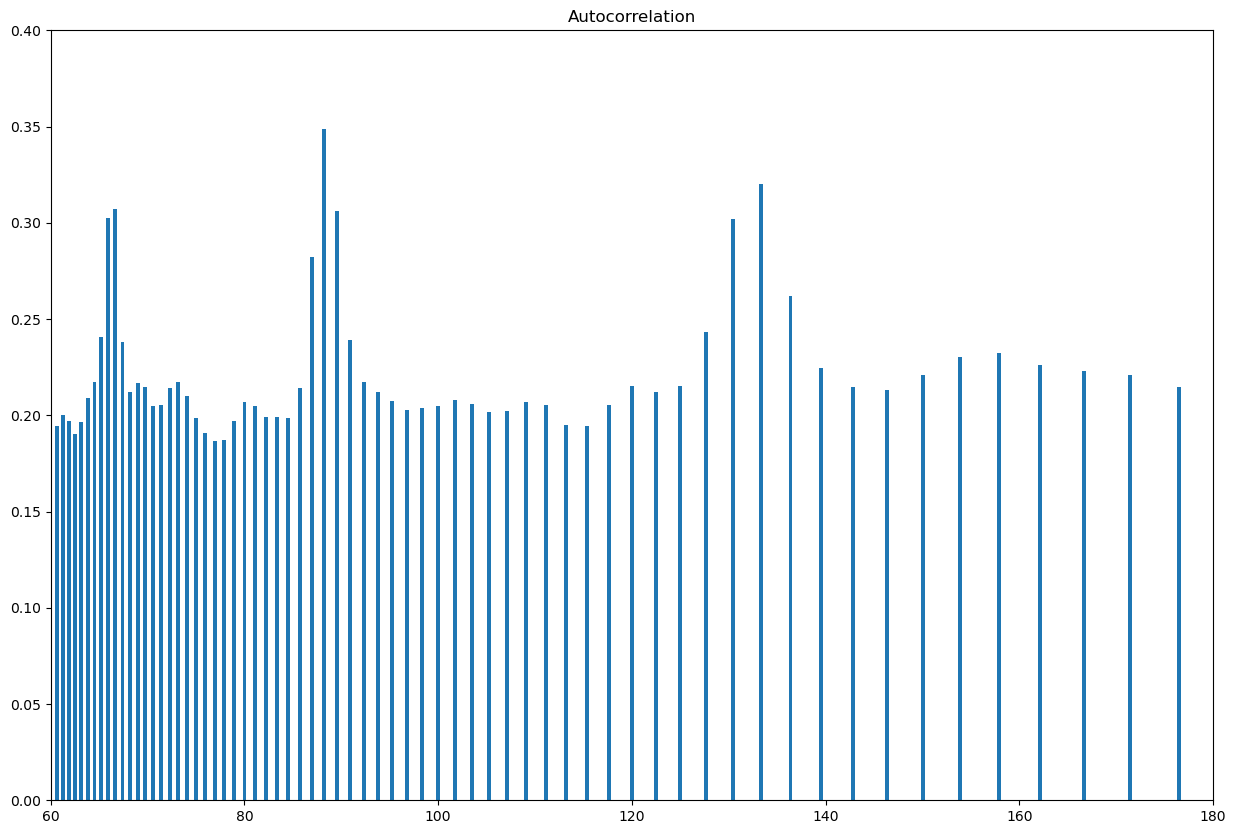

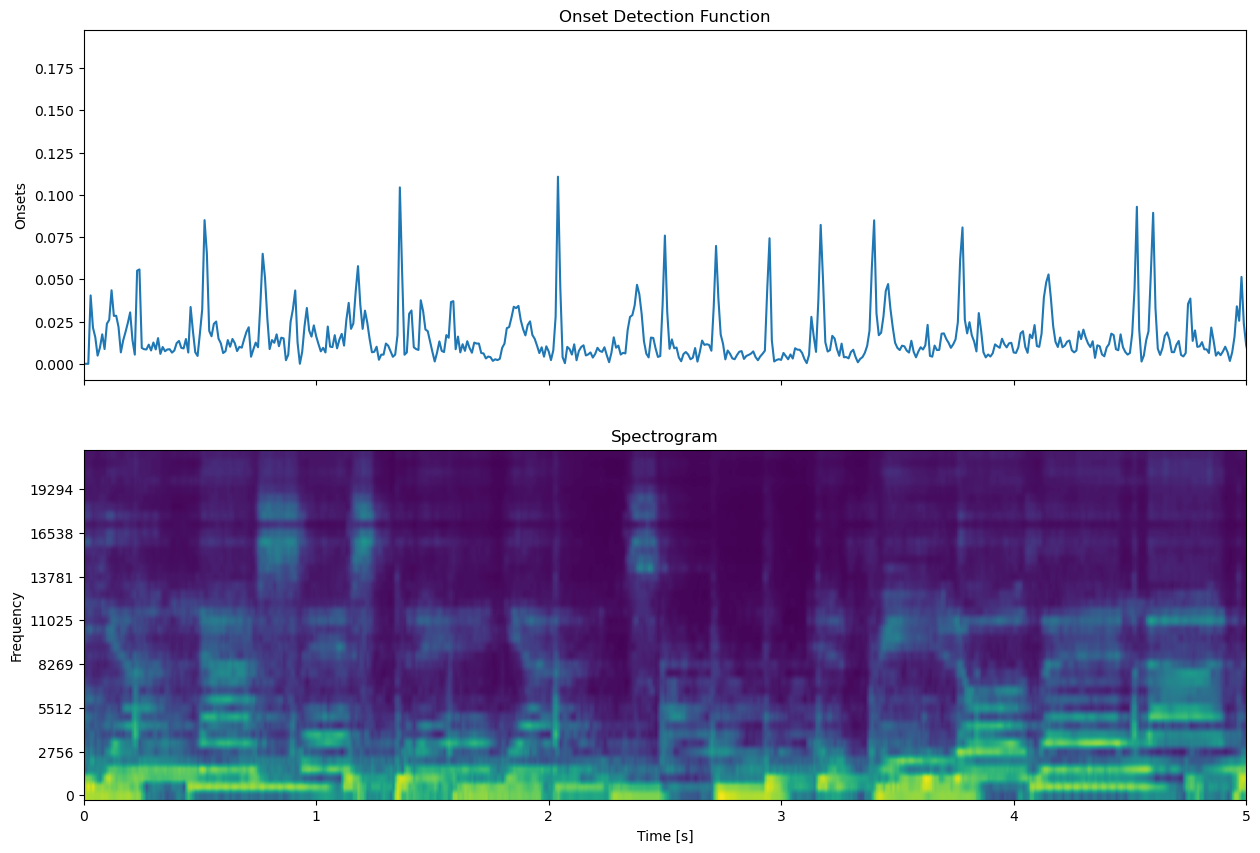

In [13]:
# DO NOT COPY OR MODIFY THIS CELL!!
plot_5s_ACF(example_spectrogram, spec_frame_rate)

In [14]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

### 1.4 Tempo Estimation Function

Now that we have all pieces to actually perform tempo detection, let's define the function to do so:

**Hint:** There exists a numpy function for getting the index of the maximum of an ndarray.

In [15]:
def estimate_tempo(spectrogram, **kwargs):
    """
    Calculate tempo estimate for audiofile represented by input spectrogram.
    
    Parameters
    ----------
    spectrogram : ndarray
                Spectrogram of audio file under analysis.
    Returns
    -------
    float
        Tempo of audio file in BPM.
    """

    min_bpm = kwargs.get('min_bpm', DEFAULT_MIN_BPM)
    max_bpm = kwargs.get('max_bpm', DEFAULT_MAX_BPM)
    
    bpm = -1
    # 1. Calculate ODF
    # 2. Calculate ACF
    # 3. Find index of maximum in ACF
    # 4. Calculate BPM using peak index and bpm_for_lag array
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    # Step 1
    odf = onset_detection_function(spectrogram)

    # Step 2
    acf,bpm_for_lag = autocorrelation(odf,min_bpm,max_bpm)

    # Step 3
    index = np.argmax(acf)

    # Step 4
    bpm = bpm_for_lag[index]

    return bpm

In [16]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

test_spec = np.zeros((1000, 80))
test_spec[20:1000:50, :] = 1
plt.figure(figsize=(12, 7))
print(estimate_tempo(test_spec))
assert estimate_tempo(test_spec) == 120

print('All tests successful!')

120.0
All tests successful!


<Figure size 1200x700 with 0 Axes>

## Task 2: Predict Tempo on Data Set (3 Points)

Finally, let's do tempo estimation for all audio files in the data set.

In [17]:
# DO NOT COPY OR MODIFY THIS CELL!!

# collect the spectrograms for files where we have tempo annotations...
tempo_specs = [audio_data['spectrograms'][idx] for idx in tempo_data['audio_idxs']]

In [18]:
def predict_tempo_for_all(spectrograms=tempo_specs, **kwargs):
    """
    Predict tempi for all files in dataset
    
    Parameters
    ----------
    spectrograms : list
        List of ndarrays which contain spectrograms for audio files.
        
    kwargs : additional arguments to be forwarded to estimate_tempo
    
    Returns
    -------
    list
        List of tempi in BPM for each audio file.
    """
    detected_tempi = []
    
    # iterate over spectrograms, estimate tempo, and put it in detected_tempi:
    # forward the kwargs to estimate_tempo
    # YOUR CODE HERE
    # raise NotImplementedError()
    for spec in spectrograms:
        BPM = estimate_tempo(spec, **kwargs)
        detected_tempi.append(BPM)
    return detected_tempi

In [19]:
# DO NOT COPY OR MODIFY THIS CELL!!

# run tempo detection on dataset...
import time
t1=time.time()
detected_tempi = predict_tempo_for_all()
print("Time used for tempo detection: {:.1f} seconds.".format(time.time()-t1))

Time used for tempo detection: 0.1 seconds.


In [20]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

assert len(detected_tempi) == len(tempo_data['annotations'])

print('All tests successful!')

All tests successful!


## Task 3: Evaluation of Tempo Estimation (6 Points)

Evaluate the mean tempo estimation performance (e.g. with `madmom.evaluation.tempo` module) on the dataset. Use
`Accuracy 1` (with 4% tolerance) and `Accuracy 2` (allowing 4% tolerance, including double and half tempo variants) as metrics.

In [21]:
# DO NOT COPY OR MODIFY THIS CELL!!

DEFAULT_TOLERANCE = 0.04

In [22]:
import madmom
def evaluate_tempo(tempi, annotations, tolerance=DEFAULT_TOLERANCE):
    """
    Evaluate detected tempi against ground truth annotations.

    Parameters
    ----------
    tempi : list
        List with tempo detections for all files.
    annotations : list
        List with corresponding ground truth annotations.

    Returns
    -------
    accuracy_1 : float
        Averaged (macro) accuracy 1.
    accuracy_2 : float
        Averaged (macro) accuracy 2.

    """
    evals = []
    
    import warnings  # NOTE: mir_eval and madmom throw warnings for empty detections / annotations, 
                     # we have to ignore those warnings, otherwise the notebook validation will fail!
                     # To do so, keep your code within this "with warnings.catch_warnings():" clause.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        # iterate over detections and annotations, as we have done in assignment 2
        # calculate metrics for each track
        # return average metrics for all tracks
        for cur_tempo, cur_annotation in zip(tempi, annotations):
            e = madmom.evaluation.tempo.TempoEvaluation(cur_tempo, cur_annotation, tolerance=tolerance)
            evals.append(e)
            pass
            
    # YOUR CODE HERE
    # raise NotImplementedError()
    result= madmom.evaluation.tempo.TempoMeanEvaluation(evals)

    accuracy_1 = result.acc1
    accuracy_2 = result.acc2
    return accuracy_1, accuracy_2

In [23]:
# tests

test_mats(evaluate_tempo([120], [120], 0.04), 
          (1.0, 1.0))
test_mats(evaluate_tempo([120, 130], [120, 160], 0.04), 
          (0.5, 0.5))
test_mats(evaluate_tempo([120, 130], [124, 130], 0.04), 
          (1.0, 1.0))
test_mats(evaluate_tempo([120, 130], [126, 130], 0.10), 
          (1.0, 1.0))

print('All tests successful!')

All tests successful!


In [24]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

# evaluate against ground truth
acc1, acc2 = \
    evaluate_tempo(detected_tempi, tempo_data['annotations'])

print(f'Tempo estimation results\nAccuracy 1: {acc1:.3f}\nAccuracy 2: {acc2:.3f} \n')

# With correct implementation and default values, you should be able to achieve at least 0.5 ACC1 and 0.8 ACC2.

assert acc1 > 0.5, "Accuracy 1 below 0.5!"
assert acc2 > 0.8, "Accuracy 2 below 0.8!"

print('All tests successful!')


Tempo estimation results
Accuracy 1: 0.571
Accuracy 2: 0.864 

All tests successful!


## Task 4: Beat Tracking (10 Points)

Finally we will apply a simple beat tracking technique, discussed in the lecture, to identify beats for the audio
excerpts.
To detect the beats, the following procedure should be applied:

1. Determine the beat phase, given the tempo determined in task 3 and select the first beat.

2. Track beats based on the tempo; allow a fixed (default = ±10%) tempo deviation between consecutive beats.


### 4.1 First Beat
The beat phase tells us where the first beat has to be placed.
A simple way to detect the beat phase is to correlate a tempo puls train with the onset detection function.
The lag with the highest correlation is a good estimate for our beat phase (= position of first beat).

Implement a function that:
1. Creates a puls train from the provided tempo in BPM
2. Correlates the puls train with the provided ODF 
3. Return the index with the highest correlation value as beat phase

The main question is how long the puls train should be and how much of the ODF should be correlated with the pulse train.
For now, use the provided default parameters - the `beat_lag` can be calculated using the tempo. `pulse_len` is a parameter for the lenght of the tempo pulse train and `corr_fac` defines for how many lags the pulse train should be correlated (as a factor to `beat_lag`).
Theoretically, the maximum lag should be `beat_lag` if we got the right tempo at first, but as you will see, correlating for larger lags may improve performance (double tempo errors, e.g.).


In [25]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

DEFAULT_PULSE_LEN = 4*spec_frame_rate
DEFAULT_CORR_FAC = 1

In [26]:
def find_beat_phase(odf, tempo, pulse_len=DEFAULT_PULSE_LEN, corr_fac=DEFAULT_CORR_FAC):
    """
    Finds the first beat by correlating a pulse train.
    
    Parameters
    ----------
    odf : ndarray
        Onset density function.
    tempo : float
        Estimated tempo, used to create pulse train.
    pulse_len : int
        Length in frames of pulse train
    corr_fac : float
        Factor for beat_lag (from tempo) which defines for how many lags correction should be done.
    Returns
    -------
    int
        Beat phase in frames
    """
    phase = 0
    
    # this is the beat intervall in frames, given our tempo hypothesis.
    beat_lag = int(np.round(bpm_to_frames(tempo)))
    # this is the number of lags we should correlate the ODF with. 
    # Output phase will be in the intervall [0..num_corr_lags]
    num_corr_lags = int(np.round(beat_lag*corr_fac))
    # 1) create pulse train with length pulse_len, all zeros, set positions with pulses (n*beat_lag) to 1
    # 2) get appropriate part of ODF to correlate with (right length!)
    # 3) correlate the two
    # 4) use index with max as phase
    # YOUR CODE HERE
    # raise NotImplementedError()

    pulse_train = np.zeros((pulse_len,))
    pulse_train[::num_corr_lags] = 1
    if len(odf)<=pulse_len:
        cross_correlate = np.correlate(odf,pulse_train[0:len(odf)], mode= 'full')
    else:
        cross_correlate = np.correlate(odf[0:pulse_len],pulse_train, mode= 'full')

    cross_correlate = cross_correlate[len(cross_correlate)//2:]

    phase = np.argmax(cross_correlate)
    
    return phase

In [27]:
# tests

test_odf = np.zeros((300, ))
test_odf[5] = 1
assert find_beat_phase(test_odf, 60) == 5

test_odf[20] = 1
test_odf[120] = 1
test_odf[125] = 1
test_odf[225] = 1
assert find_beat_phase(test_odf, 60) == 20

print('All tests successful!')

All tests successful!


### 4.2 Beat Tracking Function
The next function should detect all peaks sequentially (greedily) using tempo, beat phase, and detected onsets.
1. Start at the first beat, which is indicated by the beat phase.
2. Check if an onset is closer then the step size multiplied with `tolerance`. <br>
3. If this is the case, use the onset as new beat location and update tempo, use `tempo_change_fac` as a scaling factor to update the tempo / step size.<br>
4. If not, just use the predicted position
5. Use the tempo to go to next estimated beat position
6. Repeat until no more onsets are available

In [28]:
# DO NOT COPY OR MODIFY THIS CELL!!

DEFAULT_TOLERANCE = 0.1  # 10%
DEFAULT_TEMPO_CHANGE_FAC = 0.5  # only use 50% of difference for tempo update...

In [29]:
def track_beats(onsets, tempo, phase, tolerance=DEFAULT_TOLERANCE, 
                tempo_change_fac=DEFAULT_TEMPO_CHANGE_FAC):
    """
    Tracks beat using onsetes, tempo, phase.
    Parameters
    ----------
    onsets : list
        List of onset times in frames (integers).
    tempo : float
        Tempo in BPM
    phase : int
        Beat phase (potential position of first beat) in frames.
    tolerance : float
        Maximum tolerance for onset position, as factor of beat intervall.
    tempo_change_fac : 
        Actual differences in intervalls will be downscaled by this factor, bevor updating tempo/beat intervall.

    Returns
    -------
    ndarray
        Array with detected beat positions.
    """
    beats = []
    # beat intervall
    delta_time = bpm_to_frames(tempo)
    # +-window to find onset at estimated beat position, i.e. distance to onset must be <= max_diff
    max_diff = int(np.ceil(delta_time*tolerance))
    # start at phase
    # 1) try to find on onset at current position +- max_diff
    # 2) if so -> use onset as beat position, if not, use current position (add beat to beats)
    # 3) if onset was found, update delta_time by scaling actuall difference with tempo_change_fac
    # 4) don't forget to also update max_diff with new delta time!
    # 5) move current position forward by delta_time 
    # 6) repeat from 1) until cur position > then max position in onsets
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    position = phase
    i = 0
    while position <= onsets[-1]+max_diff:
        for onset in onsets:
            if (position-max_diff) <= onset <= (position+max_diff):
                beats.append(onset)
                tempo += (position-onset)*tempo_change_fac
                delta_time = np.round(bpm_to_frames(tempo))
                max_diff = int(np.ceil(delta_time*tolerance))
                # position = onset
                break
        else:
            beats.append(position)  

        position += delta_time

    return np.asarray(beats)


In [30]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
score = 0.0
try:
    test_onsets = np.asarray([40, 90, 140, 190], dtype=float)
    exp_beats =   np.asarray([40, 90, 140, 190], dtype=float)
    beats = track_beats(test_onsets, 120, 40, tempo_change_fac=0)
    test_mats(beats, test_onsets)
    score+=1.0

    # additional onsets
    test_onsets = np.asarray([40, 60, 80, 180, 200, 280, 290, 380], dtype=float)
    exp_beats =   np.asarray([        80, 180, 280,           380], dtype=float)
    beats = track_beats(test_onsets, 60, 80, tempo_change_fac=0)
    test_mats(beats, exp_beats)
    score+=1.0

    # changing tempo
    test_onsets = np.asarray([40, 90, 140, 190, 243, 296, 344, 391, 440], dtype=float)
    exp_beats =   np.asarray([40, 90, 140, 190, 243, 296, 344, 391, 440], dtype=float)
    beats = track_beats(test_onsets, 120, 40)
    test_mats(beats, exp_beats)
    score+=1.0
    
    # changing tempo with additional onsets
    test_onsets = np.asarray([40, 90, 140, 145, 160, 190, 243, 255, 265, 297, 344, 391, 440], dtype=float)
    exp_beats =   np.asarray([40, 90, 140,           190, 243,           297, 344, 391, 440], dtype=float)
    beats = track_beats(test_onsets, 120, 40)
    test_mats(beats, exp_beats)
    score+=1.0
    
    print('All tests successful!')
except: 
    traceback.print_exc()
    print(f'Some tests failed!')
print(f"score = {score}/4.0")
score

All tests successful!
score = 4.0/4.0


4.0

### 4.3 Track Beats on Dataset
Implement the function below that performs the full beat tracking algorithm, using the steps discussed at the beginning of this chapter.

In [31]:
def predict_beats(spectrogram, **kwargs):
    """
    Calculcate beats for the audio file represented by the provided spectrogram.
    
    Parameters
    ----------
    spectrogram : ndarray
                Spectrogram of audio file under analysis.
    Returns
    -------
    beats : list
        List of beat positions IN SECONDS!
    """
    
    # get kwargs for tempo:
    min_bpm = kwargs.get('min_bpm', DEFAULT_MIN_BPM)
    max_bpm = kwargs.get('max_bpm', DEFAULT_MAX_BPM)
    # get kwargs for onsets:
    onset_thresh = kwargs.get('onset_thresh', 0.2)
    # get kwargs for phase:
    corr_fac = kwargs.get('corr_fac', DEFAULT_CORR_FAC)
    pulse_len = kwargs.get('pulse_len', DEFAULT_PULSE_LEN)
    # get kwargs for tracking:
    tolerance = kwargs.get('tolerance', DEFAULT_TOLERANCE)
    tempo_change_fac = kwargs.get('tempo_change_fac', DEFAULT_TEMPO_CHANGE_FAC)
    
    # use our tempo estimation to get the bpm
    bpm = estimate_tempo(spectrogram, min_bpm=min_bpm, max_bpm=max_bpm)

    # Onset detection - we want to be conservative here, to get high precision!
    # Since we did onset detection in the last assignment already, 
    # we will use the madmom implementation here to keep the assignment more compact. 
    from madmom.features.onsets import peak_picking, combine_events
    ce_delta = 3
    odf = onset_detection_function(spectrogram)
    peak_candidates = peak_picking(odf/odf.max(), onset_thresh)
    onsets = np.asarray(combine_events(peak_candidates, ce_delta, 'left'), dtype=int)

    beats = []
    # NOTE: use the parameters extracted from the kwargs for fine_beat_phase and track_beats!!
    # track beats:
    # 1) find beat phase
    # 2) track beats
    # 3) convert from frames to seconds
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    # Step 1
    beat_phase = find_beat_phase(odf, bpm,pulse_len,corr_fac)
    # Step 2
    beats = track_beats(onsets, bpm, beat_phase,tolerance,tempo_change_fac)
    # Step 3
    beats = [beat/spec_frame_rate for beat in beats]
    return beats

Get all audio files with beat annotations, and run beat tracking for all of them:

In [32]:
# DO NOT COPY OR MODIFY THIS CELL!!
beat_specs = [audio_data['spectrograms'][idx] for idx in beat_data['audio_idxs']]

In [33]:
# DO NOT COPY OR MODIFY THIS CELL!!
def predict_beats_for_all(spectrograms=beat_specs, **kwargs):
    # list for collecting the onset detections, sorted in the same way
    detected_beats = []
    for idx, spectrogram in enumerate(spectrograms):
        detected_beats.append(predict_beats(spectrogram, **kwargs))
    return detected_beats

In [34]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!
detected_beats = predict_beats_for_all()

assert len(detected_beats) == len(beat_data['annotations']), "beats should be returned for each spectrogram"

assert np.all([len(cur_beats) > 0 for cur_beats in detected_beats]), "detected beats must not be empty!"

print('All tests successful!')

All tests successful!


## Task 5: Evaluate Beat Tracking (6 Points)

Evaluate beat tracking performance using the `madmom.evaluation.beats` module on the dataset. Use `fmeasure`, `CMLt`,  and `AMLt` as evaluation metrics. For parameters, go with defaults.

**Additionally**, calculate a mean phase accuracy - check if the detected first beat is within `phase_tol` to any annotation, to see how well our phase detection is performing.
If the phase (first beat in detections) correlates with a beat in annotations, add 1, else add 0, and divide by the number of tracks in the end.

In [35]:
def evaluate_beats(beats, annotations, phase_tol=0.05):
    """
    Evaluate detected beats against ground truth annotations.

    Parameters
    ----------
    beats : list
        List with beat detections for all files.
    annotations : list
        List with corresponding ground truth annotations.

    Returns
    -------
    cmlt : float
        Averaged CMLt.
    amlt : float
        Averaged AMLt.
    fmeasure : float
        Averaged f-measure.
    phase_acc : float
        Averaged phase accuracy.

    """

    from madmom.evaluation.beats import BeatEvaluation, BeatMeanEvaluation
    phase_acc = 0
    
    import warnings  # NOTE: mir_eval and madmom throw warnings for empty detections / annotations, 
                 # we have to ignore those warnings, otherwise the notebook validation will fail!
                 # To do so, keep your code within this "with warnings.catch_warnings():" clause.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        # iterate over detections and annotations, as we have done in assignment 2
        # calculate metrics for each track
        # return average metrics for all 
        metrics = []
        phase = 0
        count = 0
        temp = False
        for cur_beats, cur_annotation in zip(beats, annotations):
            e = madmom.evaluation.beats.BeatEvaluation(cur_beats, cur_annotation)
            metrics.append(e)
            # print(cur_beats)
            # print(cur_annotation)
            try:
                if cur_annotation[0]-phase_tol <= cur_beats[0] <= cur_annotation[0]+phase_tol:
                    phase += 1
                    temp = True
            except:
                phase_acc = 1
            count += 1
            pass
        
    # YOUR CODE HERE
    # raise NotImplementedError()
    result= madmom.evaluation.beats.BeatMeanEvaluation(metrics)
    print(result)
    cmlt = result.cmlt
    amlt = result.amlt
    fmeasure = result.fmeasure
    if temp:
        phase_acc = phase/count
    return cmlt, amlt, fmeasure, phase_acc

In [36]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

test_mats(evaluate_beats([[]], [[]], 0.05), 
          (1.0, 1.0, 1.0, 1.0))
test_mats(evaluate_beats([[1.0, 2.0]], [[1.0, 2.0]], 0.05), 
          (1.0, 1.0, 1.0, 1.0))
test_mats(evaluate_beats([[0.02, 3.5]], [[0.04, 3.55]], 0.1), 
          (1.0, 1.0, 1.0, 1.0))

test_mats(evaluate_beats([[0.5, 1.0], [0.5, 1.5, 2.0, 2.5]], 
                         [[0.5, 1.0], [1.0, 1.5, 2.0, 2.5]], 0.1), 
          (0.75, 0.75, 0.875, 0.5))


print('All tests successful!')

mean for 1 files
  F-measure: 1.000 P-score: 1.000 Cemgil: 1.000 Goto: 1.000 CMLc: 1.000 CMLt: 1.000 AMLc: 1.000 AMLt: 1.000 D: 5.322 Dg: 5.322
mean for 1 files
  F-measure: 1.000 P-score: 1.000 Cemgil: 1.000 Goto: 1.000 CMLc: 1.000 CMLt: 1.000 AMLc: 1.000 AMLt: 1.000 D: 5.322 Dg: 5.322
mean for 1 files
  F-measure: 1.000 P-score: 1.000 Cemgil: 0.670 Goto: 1.000 CMLc: 1.000 CMLt: 1.000 AMLc: 1.000 AMLt: 1.000 D: 4.322 Dg: 4.322
mean for 2 files
  F-measure: 0.875 P-score: 0.875 Cemgil: 0.875 Goto: 1.000 CMLc: 0.750 CMLt: 0.750 AMLc: 0.750 AMLt: 0.750 D: 4.916 Dg: 4.672
All tests successful!


In [37]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

# evaluate against ground truth
cmlt, amlt, fmeasure, phacc =\
    evaluate_beats(detected_beats, beat_data['annotations'])

print('Beat tracking results\ncmlt:      {:.3f}\n' \
      'amlt:      {:.3f}\n-----------------\n' \
      'fmeasure:  {:.3f}\nphase acc: {:.3f}\n'
      .format(cmlt, amlt, fmeasure, phacc))

# With correct implementation and default values, you should be able to achieve the performance values below:

assert cmlt > 0.2, "cmlt should be above 0.2!"
assert amlt > 0.4, "amlt should be above 0.4!"
assert fmeasure > 0.4, "fmeasure should be above 0.4!"
assert phacc > 0.4, "phacc should be above 0.4!"

print('All tests successful!')



mean for 177 files
  F-measure: 0.557 P-score: 0.561 Cemgil: 0.490 Goto: 0.435 CMLc: 0.351 CMLt: 0.382 AMLc: 0.623 AMLt: 0.680 D: 2.480 Dg: 0.566
Beat tracking results
cmlt:      0.382
amlt:      0.680
-----------------
fmeasure:  0.557
phase acc: 0.554

All tests successful!


## Task 6: Optimize Beat Tracking Results (6 Points)

Optimize the parameters to get the best performance on the dataset.
Parameters to be optimised: allowed deviation of the tempo, length of the audio used to determine the tempo.

Again, use the kwargs in `predict_beats_for_all` and forward them to the subroutines.

In [38]:
def detect_beats_optimized():
    # detected_beats_o = predict_beats_for_all(min_bpm=DEFAULT_MIN_BPM, 
    #                                         max_bpm=DEFAULT_MAX_BPM,
    #                                         onset_thresh=0.2,
    #                                         pulse_len=DEFAULT_PULSE_LEN,
    #                                         corr_fac=DEFAULT_CORR_FAC,
    #                                         tolerance=DEFAULT_TOLERANCE,
    #                                         tempo_change_fac = DEFAULT_TEMPO_CHANGE_FAC)

    # YOUR CODE HERE
    # raise NotImplementedError()
    '''
    DEFAULT_PULSE_LEN = 4*spec_frame_rate
    DEFAULT_CORR_FAC = 1
    
    DEFAULT_TOLERANCE = 0.1  # 10%
    DEFAULT_TEMPO_CHANGE_FAC = 0.5  # only use 50% of difference for tempo update...
    '''
    min_bpm=DEFAULT_MIN_BPM
    max_bpm=DEFAULT_MAX_BPM
    onset_thresh=0.2
    pulse_len=int(2.5*spec_frame_rate)
    corr_fac = DEFAULT_CORR_FAC
    tolerance= DEFAULT_TOLERANCE
    tempo_change_fac = 0.25
    
    detected_beats_o = predict_beats_for_all(min_bpm=min_bpm, 
                                             max_bpm=max_bpm,
                                             onset_thresh=0.2,
                                             pulse_len=pulse_len,
                                             corr_fac=corr_fac,
                                             tolerance=tolerance,
                                             tempo_change_fac = tempo_change_fac)


    return detected_beats_o
# Below a grid search was performed in order to find the best combinations. It was observed that if 
# the length of the pulse and the tempo changing were modified, the cmlt and the phase accuracy were changing.
# Thereforem these are the two parameters that were optimized
# import itertools
# def detect_beats_optimized():
#     # detected_beats_o = predict_beats_for_all(min_bpm=DEFAULT_MIN_BPM, 
#     #                                         max_bpm=DEFAULT_MAX_BPM,
#     #                                         onset_thresh=0.2,
#     #                                         pulse_len=DEFAULT_PULSE_LEN,
#     #                                         corr_fac=DEFAULT_CORR_FAC,
#     #                                         tolerance=DEFAULT_TOLERANCE,
#     #                                         tempo_change_fac = DEFAULT_TEMPO_CHANGE_FAC)

#     # YOUR CODE HERE
#     # raise NotImplementedError()

#     DEFAULT_PULSE_LEN = 4*spec_frame_rate
#     DEFAULT_CORR_FAC = 1
    
#     DEFAULT_TOLERANCE = 0.1  # 10%
#     DEFAULT_TEMPO_CHANGE_FAC = 0.5  # only use 50% of difference for tempo update...

#     min_bpm=DEFAULT_MIN_BPM
#     max_bpm=DEFAULT_MAX_BPM
#     onset_thresh=0.2
#     pulse_len=[int(2*spec_frame_rate),int(2.5*spec_frame_rate),int(3*spec_frame_rate),int(3.5*spec_frame_rate),int(4*spec_frame_rate),int(5*spec_frame_rate),int(6*spec_frame_rate)]
#     corr_fac = [1,2,3]
#     tolerance= DEFAULT_TOLERANCE
#     tempo_change_fac = [0.05,0.1,0.15,0.20,0.25,0.3]
    
#     best_params = None
#     best_scores = {'cmlt_o': 0.4, 'amlt_o': 0.6, 'fmeasure_o': 0.5, 'phacc_o': 0.6}

#     for params in itertools.product(pulse_len, corr_fac, tempo_change_fac):
#         pulse_len, corr_fac, tempo_change_fac = params
#         detected_beats_o = predict_beats_for_all(min_bpm=min_bpm, 
#                                                  max_bpm=max_bpm,
#                                                  onset_thresh=0.2,
#                                                  pulse_len=pulse_len,
#                                                  corr_fac=corr_fac,
#                                                  tolerance=tolerance,
#                                                  tempo_change_fac = tempo_change_fac)
        
#         # Calculate scores based on the result
#         cmlt_o, amlt_o, fmeasure_o, phacc_o = evaluate_beats(detected_beats_o, beat_data['annotations'])
#         if cmlt_o > best_scores['cmlt_o'] and amlt_o > best_scores['amlt_o'] \
#                 and fmeasure_o > best_scores['fmeasure_o'] and phacc_o > best_scores['phacc_o']:
#             best_scores['cmlt_o'] = cmlt_o
#             best_scores['amlt_o'] = amlt_o
#             best_scores['fmeasure_o'] = fmeasure_o
#             best_scores['phacc_o'] = phacc_o
#             best_params = params
#             print("Best Parameters:", best_params)
#             print("Best Scores:", best_scores)
#             break
#     return detected_beats_o

In [39]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!

detected_beats_o = detect_beats_optimized()
cmlt_o, amlt_o, fmeasure_o, phacc_o = \
    evaluate_beats(detected_beats_o, beat_data['annotations'])

print('Beat tracking results\ncmlt:      {:.3f}\n' \
      'amlt:      {:.3f}\n-----------------\n' \
      'fmeasure:  {:.3f}\nphase acc: {:.3f}\n'
      .format(cmlt_o, amlt_o, fmeasure_o, phacc_o))

# With optimized values, you should be able to achieve the performance values below:

assert cmlt_o > 0.4
assert amlt_o > 0.6
assert fmeasure_o > 0.5
assert phacc_o > 0.6

print('All tests successful!')



mean for 177 files
  F-measure: 0.582 P-score: 0.582 Cemgil: 0.510 Goto: 0.429 CMLc: 0.364 CMLt: 0.402 AMLc: 0.663 AMLt: 0.726 D: 2.617 Dg: 0.630
Beat tracking results
cmlt:      0.402
amlt:      0.726
-----------------
fmeasure:  0.582
phase acc: 0.605

All tests successful!


## Task 7: Visualize Results (4 Points)

Take the example from the very beginning and produce some well formatted plots that show:
1. Audio signal
2. Spectrogram
3. ACF and peak
4. Beats and annotations over ODF

For plots for 1, 2, and 4, align the time axis!

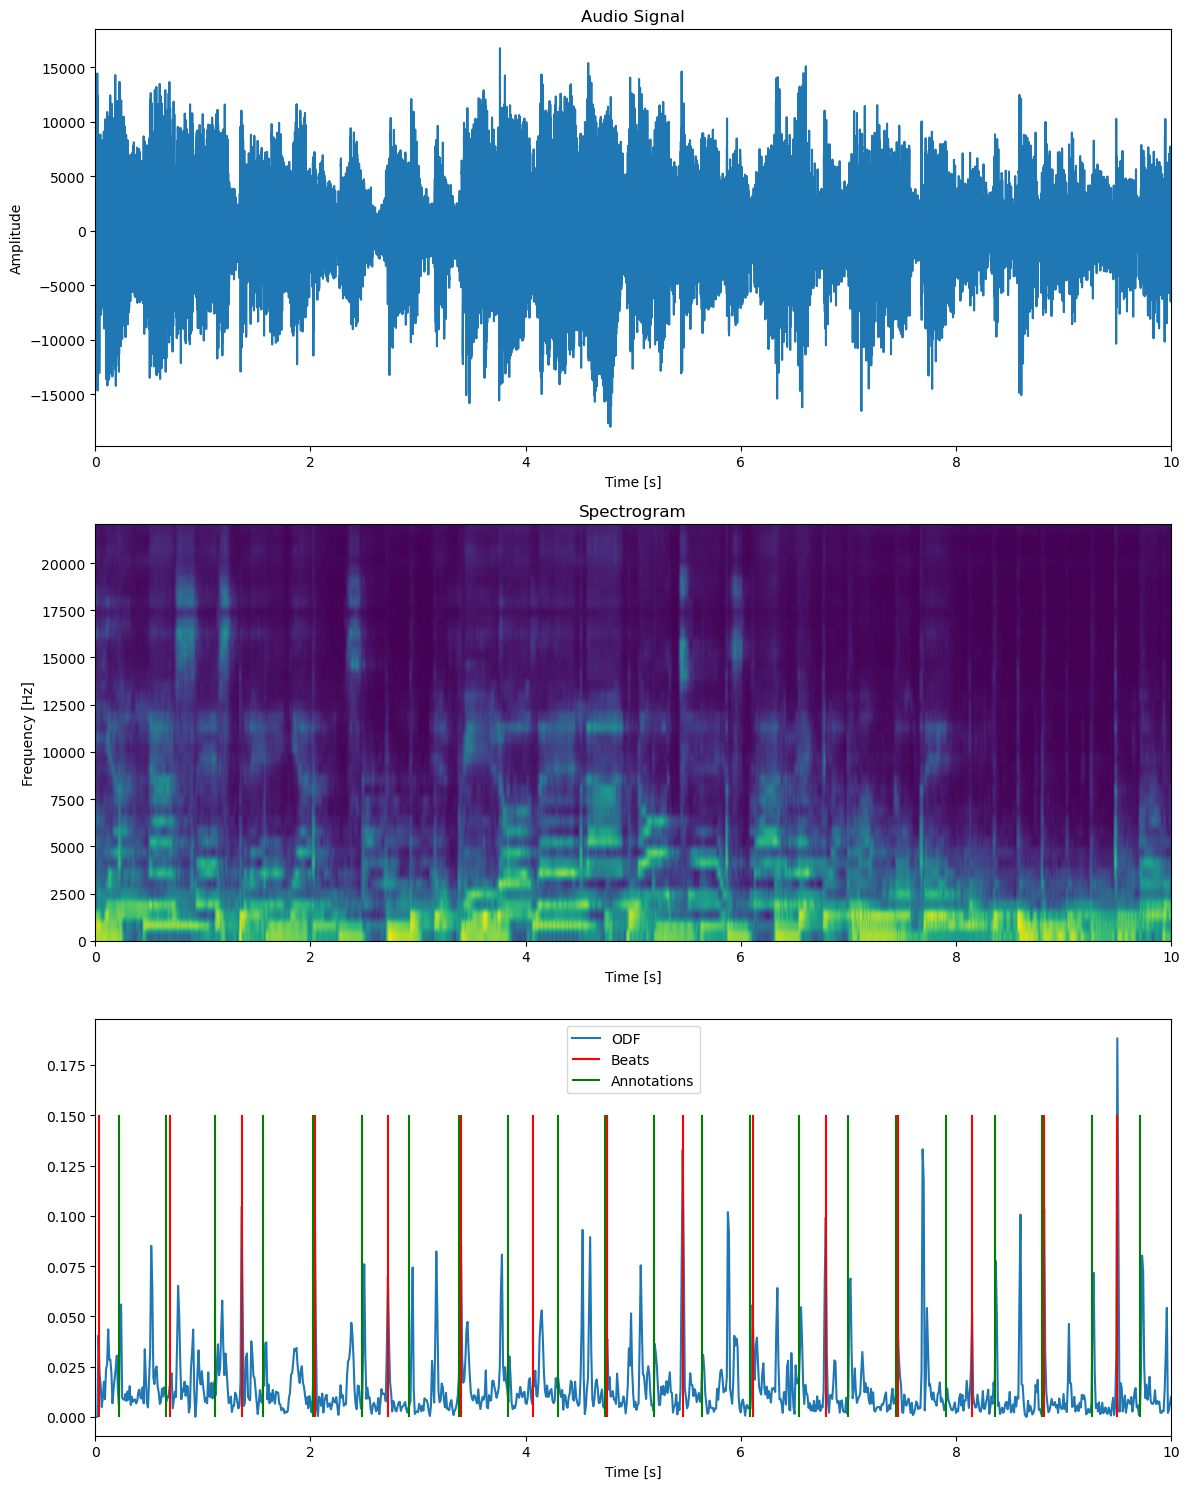

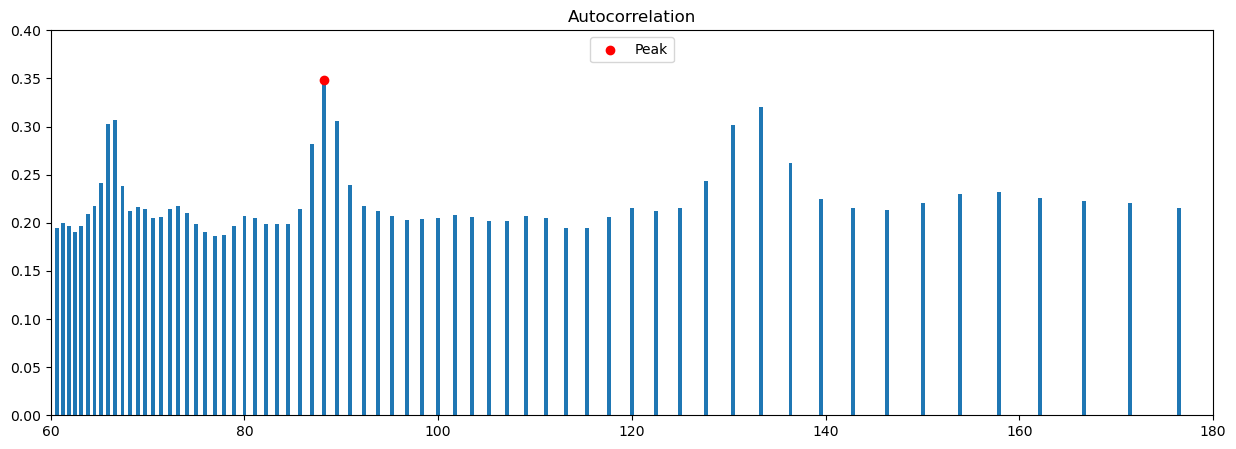

In [40]:
import matplotlib.pyplot as plt

# YOUR CODE HERE
# raise NotImplementedError()
odf = onset_detection_function(example_spectrogram)
acf,tempo = autocorrelation(odf)
beats = predict_beats(example_spectrogram)

# Audio Signal
samplerate = audio_sample_rate
data = example_audio
length = data.shape[0] / samplerate
time_audio = np.linspace(0., length, data.shape[0])

# Spectrogram
bins = spec_freq_bins
frame_rate = spec_frame_rate
frame = list(range(len(odf)))
time_spectrogram = [i / frame_rate for i in frame]
spectrogram = example_spectrogram.T
fraction = [i / bins for i in range(example_spectrogram.shape[1])]
frequency = [round(frac * audio_sample_rate / 2) for frac in fraction]

# Beats and annotations over ODF
beats_seconds_to_frames = [int(i * frame_rate) for i in beats]
example_beats_ann_to_frames = [int(i * frame_rate) for i in example_beats_ann]

# Plotting
plt.figure(figsize=(12, 15))

# Audio Signal Plot
plt.subplot(3, 1, 1)
plt.plot(time_audio, data)
plt.xlim(0, length)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Audio Signal")

# Spectrogram Plot
plt.subplot(3, 1, 2)
plt.imshow(spectrogram, origin='lower', aspect='auto', extent=[0, length, 0, audio_sample_rate / 2])
plt.title("Spectrogram")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

# Beats and Annotations Plot
plt.subplot(3, 1, 3)
plt.plot(time_spectrogram, odf, label='ODF')
plt.vlines([beat / frame_rate for beat in beats_seconds_to_frames], ymin=0, ymax=0.15, colors='red', label='Beats')
plt.vlines([ann / frame_rate for ann in example_beats_ann_to_frames], ymin=0, ymax=0.15, colors='green', label='Annotations')
plt.xlim(0, length)
plt.xlabel("Time [s]")
plt.legend(loc='upper center')

plt.tight_layout()
plt.show()

# Autocorrelation Function
plt.figure(figsize=(15, 5))
plt.bar(tempo,acf,width=0.4)
plt.xlim(DEFAULT_MIN_BPM, DEFAULT_MAX_BPM)
plt.ylim(0, 0.4)

max_index = np.argmax(acf)

plt.scatter(tempo[max_index], acf[max_index], c='r', marker='o', label='Peak')
plt.title('Autocorrelation')
plt.legend(loc='upper center')
plt.show()

In [41]:
# tests, DO NOT COPY OR MODIFY THIS CELL!!


## Congratulations, you are done!

Reminder:
Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).